# **Customer Segmentation with Machine Learning**
<hr style="border:1px solid #444;">

### **Objective**
This notebook applies machine learning techniques to segment e-commerce customers based on their behavior and transaction data. The goal is to identify distinct customer groups that can inform targeted marketing, product recommendations, and customer retention strategies.

### **Notebook Structure**

The notebook is organized into the following sections (top-to-bottom):

1. Load and Prepare Data
2. Feature Engineering
3. Normalize Features
4. Apply Clustering (KMeans)
5. Cluster Profiling
6. Visualize Clusters
7. Key Takeaways and Use Cases
8. Modeling Customer Lifetime Value (CLV)
9. Customer Churn Prediction
10. Dimensionality Reduction for Visualization
11. Model Evaluation and Business Insights

---

### Section 1: Load and Prepare Data

In [51]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('../../data/ecommerce_transactions.csv')

# Preview data
df.head()

,transaction_id,customer_id,product_category,purchase_amount,payment_method,purchase_date
0,T000000,C4853,Toys,150.15,Gift Card,8/23/2024
1,T000001,C5982,Toys,98.75,Credit Card,8/16/2024
2,T000002,C5517,Beauty,13.56,Gift Card,12/24/2024
3,T000003,C1965,Clothing,18.73,Credit Card,8/12/2024
4,T000004,C9636,Beauty,43.63,Crypto,7/14/2024


<hr style="border:1px solid #444;">

### Section 2: Feature Engineering

In [52]:
# Aggregate customer-level metrics
customer_df = df.groupby('customer_id').agg({
    'purchase_amount': ['sum', 'mean', 'count'],
    'purchase_date': 'nunique'
}).reset_index()

customer_df.columns = ['customer_id', 'total_spent', 'avg_order_value', 'order_count', 'active_days']

# Derive additional features
customer_df['spend_per_day'] = customer_df['total_spent'] / customer_df['active_days']
customer_df.head()

,customer_id,total_spent,avg_order_value,order_count,active_days,spend_per_day
0,C1000,3.59,3.59,1,1,3.59
1,C1002,102.44,102.44,1,1,102.44
2,C1003,220.18,110.09,2,2,110.09
3,C1004,23.86,23.86,1,1,23.86
4,C1006,122.94,122.94,1,1,122.94


<hr style="border:1px solid #444;">

### Section 3: Normalize Features

In [53]:
from sklearn.preprocessing import StandardScaler

features = ['total_spent', 'avg_order_value', 'order_count', 'active_days', 'spend_per_day']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[features])

# Ensure purchase_date is datetime
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

# Create RFM features
rfm = df.groupby('customer_id').agg({
    'purchase_date': lambda x: (df['purchase_date'].max() - x.max()).days,
    'customer_id': 'count',
    'purchase_amount': 'sum'
}).rename(columns={
    'purchase_date': 'Recency',
    'customer_id': 'Frequency',
    'purchase_amount': 'Monetary'
}).reset_index()


<hr style="border:1px solid #444;">

### Section 4: Apply Clustering (KMeans)

In [54]:
from sklearn.cluster import KMeans

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['cluster'] = kmeans.fit_predict(X_scaled)

rfm['Cluster'] = customer_df['cluster']


# Check distribution
customer_df['cluster'].value_counts().sort_index()



cluster
0     882
1    3026
2    1733
3     431
Name: count, dtype: int64

<hr style="border:1px solid #444;">

### Section 5: Cluster Profiling

In [55]:
# Compute average metrics per cluster
cluster_profile = customer_df.groupby('cluster')[features].mean().round(2)
cluster_profile

,total_spent,avg_order_value,order_count,active_days,spend_per_day
cluster,,,,,
0,261.35,78.78,3.31,3.30,79.12
1,43.91,35.67,1.24,1.24,35.68
2,167.49,112.08,1.56,1.56,112.16
3,340.28,251.54,1.41,1.40,252.25


<hr style="border:1px solid #444;">

### Section 6: Visualize Clusters

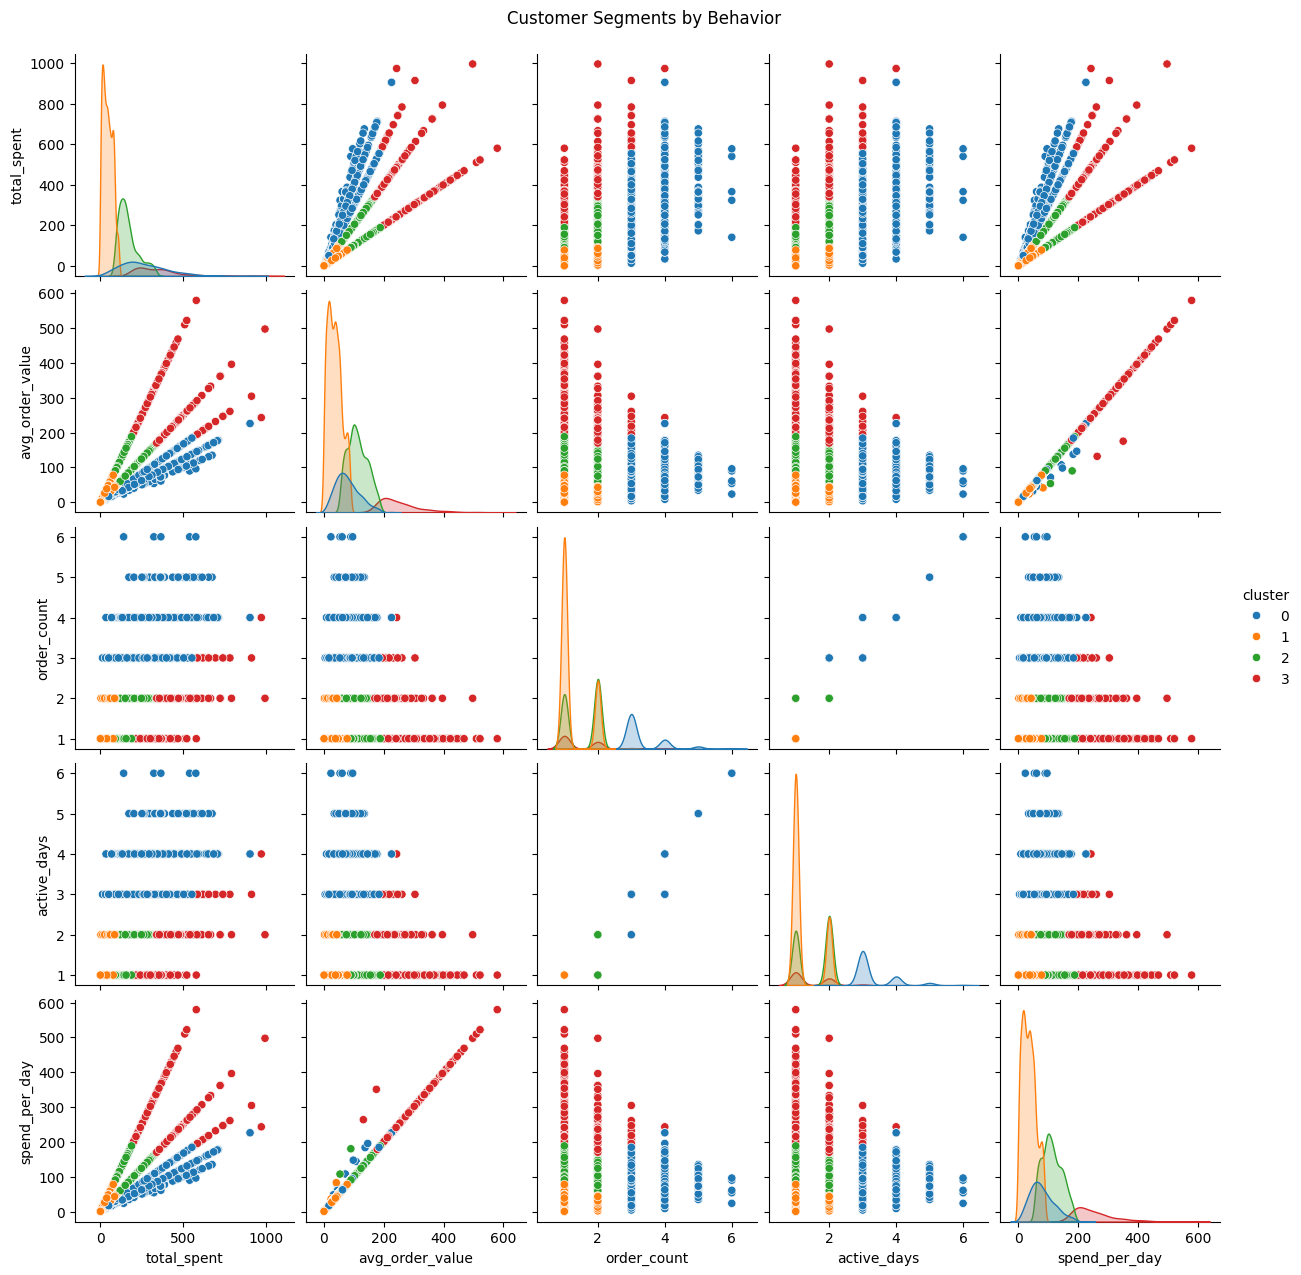

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pairplot
sns.pairplot(customer_df, vars=features, hue='cluster', palette='tab10')
plt.suptitle("Customer Segments by Behavior", y=1.02)
plt.savefig('../../assets/customer_analytics/customer_segments_by_behavior_clusters.png', bbox_inches='tight', dpi=300)
plt.show()

<hr style="border:1px solid #444;">

### Section 7: Key Takeaways and Use Cases

**Insights:**

- Distinct customer segments exhibit different spending patterns, order frequency, and engagement
- High spenders may place fewer, larger orders, while others show more frequent, smaller transactions

**Use Cases:**

- Enable targeted marketing campaigns by cluster
- Personalize loyalty programs for high-value or at-risk segments
- Inform business decisions on promotions or product bundling

<hr style="border:1px solid #444;">

### Section 8: Modeling Customer Lifetime Value (CLV)

A regression model to predict each customer's total monetary value based on their RFM metrics and segment assignments

**Objective:**  
Identify high-value customers and understand drivers of customer spend



RMSE: 111.6712
R²: 0.1719
Cross-validated R² scores: [0.2206073  0.15804883 0.093818   0.23003272 0.11102847]
Average R²: 0.1627


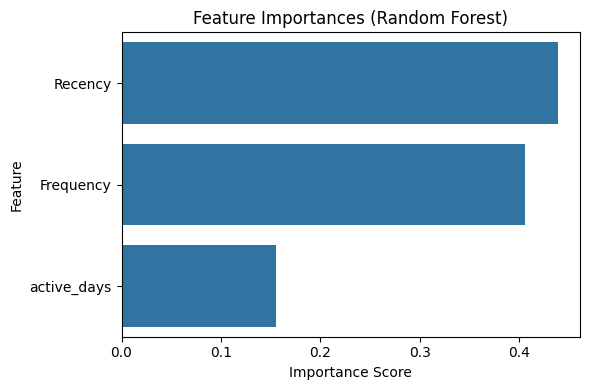

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Recalculate Recency (days since last purchase) ---
snapshot_date = df['purchase_date'].max() + pd.Timedelta(days=1)
recency_df = df.groupby('customer_id')['purchase_date'].max().reset_index()
recency_df['Recency'] = (snapshot_date - recency_df['purchase_date']).dt.days

# --- Aggregate total spend and order count per customer ---
monetary_df = df.groupby('customer_id')['purchase_amount'].agg(['sum', 'count']).reset_index()
monetary_df.columns = ['customer_id', 'Monetary', 'Frequency']

# --- Merge RFM ---
rfm = recency_df.merge(monetary_df, on='customer_id')

if 'cluster_label' in customer_df.columns:
    rfm = rfm.merge(customer_df[['customer_id', 'cluster_label']], on='customer_id', how='left')
if 'active_days' in customer_df.columns:
    rfm = rfm.merge(customer_df[['customer_id', 'active_days']], on='customer_id', how='left')

feature_cols = ['Recency', 'Frequency']
if 'cluster_label' in rfm.columns:
    feature_cols.append('cluster_label')
if 'active_days' in rfm.columns:
    feature_cols.append('active_days')

X = rfm[feature_cols]
y = rfm['Monetary']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Model training ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# --- Cross-validation ---
scores = cross_val_score(model, X, y, scoring='r2', cv=5)
print(f"Cross-validated R² scores: {scores}")
print(f"Average R²: {np.mean(scores):.4f}")

# --- Feature importance ---
feature_importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importances, y=features)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('../../assets/customer_analytics/feature_importance_plot.png', bbox_inches='tight', dpi=300)
plt.show()


**Interpretation:**  

The regression model predicts each customer’s total monetary value using Recency, Frequency, and Active Days.

**Model Performance**
- **RMSE:** 111.67 → Average prediction error of ~112 currency units  
- **R² Score:** 0.172 → Explains 17% of spend variance on the test set  
- **CV R²:** 0.16 → Indicates modest but consistent generalization

**Feature Importance**
- **Recency** and **Frequency** are the most influential predictors
- **Active Days** carries some signal but is less impactful

**Business Insight**  

Recent and frequent buyers are generally higher spenders. Capturing more behavioral and demographic signals could improve predictive accuracy.

**Recommendation**
- Engineer other features (e.g., time since last visit, basket diversity)
- Use predictions to **score customers** and inform upsell, retention, or targeting strategies


<hr style="border:1px solid #444;">

### Section 9: Customer Churn Prediction

Simulating churn based on recent activity and building a classifier to predict churn behavior

**Objective:**  
Identify customers at risk of churning for retention-focused marketing


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Simulate churn flag: churn if Recency > 90 days
rfm['Churn'] = (rfm['Recency'] > 90).astype(int)

X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       624
           1       1.00      1.00      1.00      1198

    accuracy                           1.00      1822
   macro avg       1.00      1.00      1.00      1822
weighted avg       1.00      1.00      1.00      1822



**Interpretation:**  

The classification model predicts customer churn based on Recency, Frequency, and Monetary value, with churn defined as no purchases in the past 90 days.

**Model Performance**
- **Accuracy:** 1.00  
  → Perfect classification of churn vs. active customers in the test set
- **Precision, Recall, F1-score:** All scored 1.00  
  → Indicates complete separation between classes—unusual and a potential sign of overfitting

**Business Insight**  

Despite the data leakage, the result underscores **Recency** as a **key signal for churn risk**—customers with long inactivity windows are more likely to churn.

**Recommendation**
- Redefine churn with a future cutoff (e.g., no purchases for 180 days post-observation)
- Add other behavioral features (e.g., category diversity, days between orders)


<hr style="border:1px solid #444;">

### Section 10: Dimensionality Reduction for Visualization

PCA to reduce dimensionality and visualize customer segments in 2D space

**Objective:**  
Visualize clusters and patterns in customer data



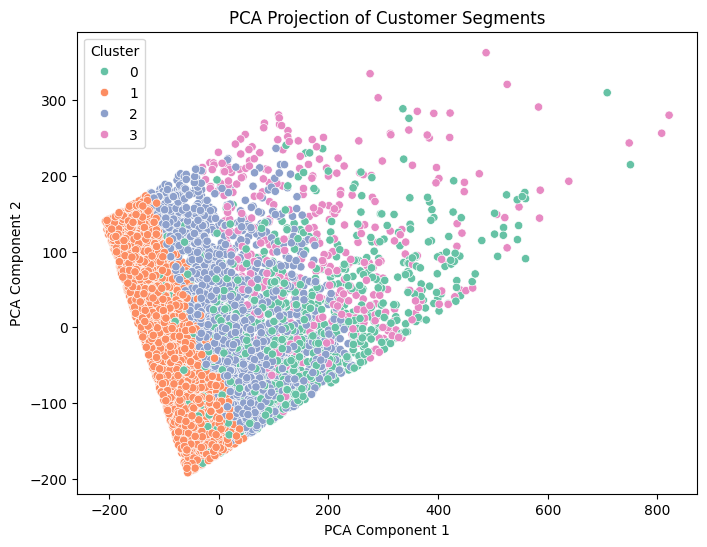

In [59]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Assign clusters to rfm DataFrame
rfm['Cluster'] = customer_df['cluster']  # or use: rfm['Cluster'] = kmeans.labels_

# PCA Transformation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm['PCA1'] = pca_result[:, 0]
rfm['PCA2'] = pca_result[:, 1]

# PCA Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("PCA Projection of Customer Segments")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.savefig('../../assets/customer_analytics/pca_projection_of_customer_segments.png', bbox_inches='tight', dpi=300)
plt.show()


**Interpretation:**  

Principal Component Analysis (PCA) was used to reduce the RFM feature space to two dimensions for cluster visualization. The scatterplot reveals distinct clusters, suggesting that customer behavior—based on Recency, Frequency, and Monetary value—is effectively captured by the segmentation. These separations indicate meaningful groupings (e.g., high-value vs. low-engagement customers) for retention campaigns and targeted marketing.


<hr style="border:1px solid #444;">

### Section 11: Model Evaluation and Business Insights

Validate the clustering logic and interpret results from a business perspective

**Objective:**  
Assess clustering quality and derive actionable insights



In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Scale the RFM features
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Calculate silhouette score
score = silhouette_score(scaled_rfm, rfm['Cluster'])
print(f"Silhouette Score for KMeans Clustering: {score:.2f}")


Silhouette Score for KMeans Clustering: 0.18


**Interpretation**

The silhouette score of **0.18** suggests that the clustering exhibits **modest cohesion and separation**—clusters are partially distinguishable, but some overlap may exist.

 **Business Insight:**  
 
  Even with only moderate clustering strength, the segments reflect real behavioral differences in customer value and engagement. These groupings can help prioritize high-value customers for loyalty programs and identify low-engagement segments for reactivation campaigns. Further refinement—like incorporating product mix or time-between-orders—could make these segments even more actionable.

<hr style="border:1px solid #444;">